## Lab assignment 02

In [53]:
import os
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import vocab as Vocab


from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import matplotlib.pyplot as plt
%matplotlib inline

#### Constants:

In [30]:
# constants
class config:
    FILE = './data.txt'
    SOS_token = 0
    EOS_token = 1
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    EPOCHS = 20
    CLIP = 1
    MAX_LENGTH = 128
    BATCH_SIZE = 32
    EMB_DIM = 256
    HID_DIM = 512

In [31]:
#!wget -qO- https://github.com/Z5-05/nlp_made_2023/raw/main/labs/lab_2/archives/dataset.tar.gz | tar xvz

if not os.path.exists(config.FILE):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

In [33]:
%%time
df = pd.read_csv(
    "data.txt", sep="\t", lineterminator="\n", header=None, names=['en', 'ru']
)

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_data, valid_data = train_df.values, valid_df.values

CPU times: user 201 ms, sys: 43 ms, total: 244 ms
Wall time: 245 ms


In [34]:
tokenizer = WordPunctTokenizer()

def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())

In [35]:
src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)
trg_vocab = Vocab(trg_counter, min_freq=2)

In [36]:
unk_token = "<unk>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

In [37]:
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

In [38]:
print(f"Unique tokens in source (en) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (ru) vocabulary: {len(trg_vocab)}")

Unique tokens in source (en) vocabulary: 10126
Unique tokens in target (ru) vocabulary: 14116


In [39]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [40]:
def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)[::-1]
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


train_dataloader = DataLoader(train_data, config.BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(valid_data, config.BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([34, 32]), torch.Size([32, 32]))

In [41]:
class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        _, hidden = self.rnn(embedded)

        return hidden
    
class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))

        return pred, hidden

In [42]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.n_tokens

        preds = []

        hidden = self.encoder(src)

        input = trg[0, :]

        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = Encoder(len(src_vocab), emb_dim=config.EMB_DIM, hid_dim=config.HID_DIM, n_layers=2, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=config.EMB_DIM, hid_dim=config.HID_DIM, n_layers=2, dropout=0.5)
model = Seq2Seq(enc, dec).to(device)

In [44]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model = model.apply(init_weights)

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 20,803,876 trainable parameters


In [46]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

In [47]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, trg_vocab):
    text = [trg_vocab.lookup_token(token) for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

def create_predictions(model, val_dataloader):  
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in enumerate(val_dataloader):

            src = batch[0].to(config.DEVICE)
            trg = batch[1].to(config.DEVICE)

            output = model(src, trg, 0) 
            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, trg_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, trg_vocab) for x in output[1:].detach().cpu().numpy().T])
    return original_text, generated_text

In [49]:
train_losses = []
val_losses = []
train_times = []
val_times = []


for epoch in range(config.EPOCHS):
    model.train()
    train_loss = 0
    for src, trg in train_dataloader:
        start_time = time.time()
        src, trg = src.to(config.DEVICE), trg.to(config.DEVICE)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), config.CLIP)
        optimizer.step()

        train_loss += loss.item()
        end_time = time.time()
        train_times.append(end_time - start_time)

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            start_time = time.time()
            src, trg = src.to(config.DEVICE), trg.to(config.DEVICE)
            output = model(src, trg)
            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)

            val_loss += loss.item()
            end_time = time.time()
            val_times.append(end_time - start_time)
    original_text, generated_text = create_predictions(model, val_dataloader)
    bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    print("Epoch: {}, train_loss: {}, val_loss: {}, val_bleu: {}".format(epoch+1, train_loss, val_loss, bleu))

Epoch: 1, train_loss: 3.9608023427963257, val_loss: 3.643902355108779, val_bleu: 8.263370806442177
Epoch: 2, train_loss: 3.574638443946838, val_loss: 3.3898119545592285, val_bleu: 10.342352714951438
Epoch: 3, train_loss: 3.3216216535568237, val_loss: 3.2581912762821674, val_bleu: 11.863986228017334
Epoch: 4, train_loss: 3.1294610914230345, val_loss: 3.1313248312892243, val_bleu: 13.161048794569771
Epoch: 5, train_loss: 2.9797585424423216, val_loss: 3.0462011056967055, val_bleu: 14.091263417275377
Epoch: 6, train_loss: 2.8510435846328734, val_loss: 3.0006096896272116, val_bleu: 14.842154255854764
Epoch: 7, train_loss: 2.7203038842201233, val_loss: 2.999735348521711, val_bleu: 16.210817046046593
Epoch: 8, train_loss: 2.6173988664627075, val_loss: 2.9464622511269565, val_bleu: 16.71378380206338
Epoch: 9, train_loss: 2.5219409023284913, val_loss: 2.9363602068477546, val_bleu: 16.9119246602191
Epoch: 10, train_loss: 2.446487125492096, val_loss: 2.9331135216612405, val_bleu: 17.3362233492791

In [50]:
original_text, generated_text = create_predictions(model, val_dataloader)

### Analyse results:

In [51]:
print(f"BLEU result: {corpus_bleu([[text] for text in original_text], generated_text) * 100}")

BLEU result: 19.460728672557163


In [54]:
print(f"Total training time // Avg time on epoch //  Avg time on batch: {sum(train_times)}, {sum(train_times)/config.EPOCHS}, {np.mean(train_times)}")

Total training time // Avg time on epoch //  Avg time on batch: 2591.267236471176, 129.5633618235588, 0.10365068945884705


In [55]:
print(f"Total eval time // Avg time on epoch //  Avg time on batch: {sum(val_times)}, {sum(val_times)/config.EPOCHS}, {np.mean(val_times)}")

Total eval time // Avg time on epoch //  Avg time on batch: 137.2064437866211, 6.860322189331055, 0.021917962266233403


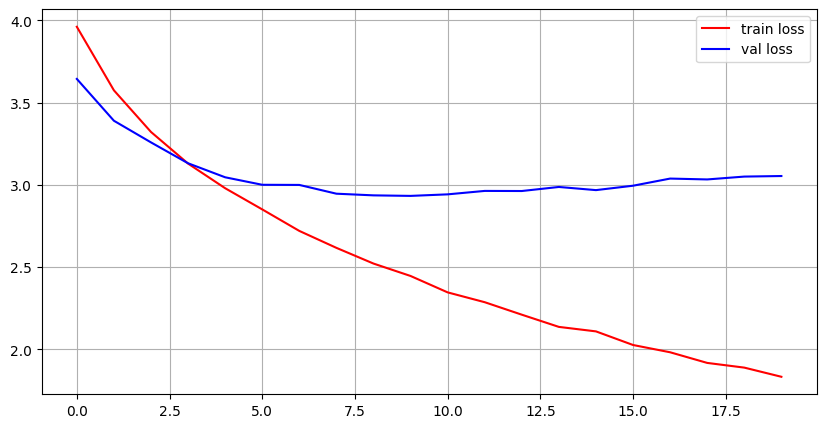

In [56]:
x = range(config.EPOCHS)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(x, train_losses, 'r', label='train loss')
plt.plot(x, val_losses, 'b', label='val loss') 
plt.legend()
plt.grid()
plt.show()

In [57]:
diff = np.array(val_losses) - np.array(train_losses)
mean_uplift = np.mean(100 * (diff[1:] - diff[:-1]) / diff[:-1])

print(f"Avg uplift of diff between train and val = {mean_uplift}")

Avg uplift of diff between train and val = 190.8202925422624


In [58]:
print("Example of best-translated sentenses:")
print("------------------------------------")
i = 0
for orig, gen in zip(original_text, generated_text):
    if set(orig) == set(gen):
        i += 1
        print(f"\t{i}) Original: {' '.join(orig)}")
        print(f"\t{i}) Generated: {' '.join(gen)}")
    if i == 10:
        break

Example of best-translated sentenses:
------------------------------------
	1) Original: предоставляется бесплатная общественная парковка .
	1) Generated: предоставляется бесплатная общественная парковка .
	2) Original: предоставляется постельное белье .
	2) Generated: предоставляется постельное белье .
	3) Original: предоставляются полотенца и постельное белье .
	3) Generated: предоставляются полотенца и постельное белье .
	4) Original: предоставляется бесплатная общественная парковка .
	4) Generated: предоставляется бесплатная общественная парковка .
	5) Original: предоставляется бесплатная частная парковка .
	5) Generated: предоставляется бесплатная частная парковка .
	6) Original: предоставляется постельное белье .
	6) Generated: предоставляется постельное белье .
	7) Original: предоставляется постельное белье .
	7) Generated: предоставляется постельное белье .
	8) Original: предоставляются тапочки и бесплатные туалетно - косметические принадлежности .
	8) Generated: предоставляютс

In [59]:
print("Example of worst-translated sentenses:")
print("------------------------------------")
i = 0
for orig, gen in zip(original_text, generated_text):
    if len(set(orig).intersection(set(gen))) == 1:
        i += 1
        print(f"\t{i}) Original: {' '.join(orig)}")
        print(f"\t{i}) Generated: {' '.join(gen)}")
    if i == 10:
        break

Example of worst-translated sentenses:
------------------------------------
	1) Original: отель villa возвышается над .
	1) Generated: находится в окружении сада .
	2) Original: побаловать себя массажем можно прямо в номере .
	2) Generated: могут заказать сеанс расслабляющего массажа .
	3) Original: собственная ванная комната укомплектована феном .
	3) Generated: собственной ванной комнате предоставляется фен .
	4) Original: сотрудники отеля круглосуточно готовы помочь организовать экскурсии по .
	4) Generated: круглосуточной стойки регистрации могут предоставить информацию о достопримечательностях .
	5) Original: гости также смогут совершать пешие походы по живописным окрестностям .
	5) Generated: окрестностях можно заняться различными видами активного отдыха , в том числе подводным плаванием .
	6) Original: рядом с номером обустроена зона для отдыха .
	6) Generated: могут провести время в гостиной в лаунджах гостевого дома .
	7) Original: также в нем располагается фермерский рынок .
